# Assignment 1: Sampler Synthesis — Starter Code

This notebook provides baseline implementations of Random Walk Metropolis-Hastings and HMC using [BlackJAX](https://blackjax-devs.github.io/blackjax/). Use these as reference points for your novel sampler.

**Your task**: Design, implement, and analyze a novel MCMC sampler. Compare it to these baselines on the benchmark distributions.

In [1]:
import arviz as az
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12

---
## Benchmark Distribution: Rosenbrock (Banana)

The Rosenbrock distribution has a curved, narrow ridge that tests how well samplers handle strong correlations and curved geometry. This is challenging because:
- The high-probability region is thin and curved
- Random walk proposals often step off the ridge
- Samplers need to follow the curved geometry efficiently

In [2]:
def log_prob_rosenbrock(theta):
    """Rosenbrock (banana) distribution.

    log p(x, y) ∝ -(1-x)²/20 - (y - x²)²

    This creates a curved, banana-shaped distribution that tests
    how well samplers handle strong correlations and curved geometry.
    """
    x, y = theta[0], theta[1]
    return -0.05 * (1 - x) ** 2 - (y - x**2) ** 2

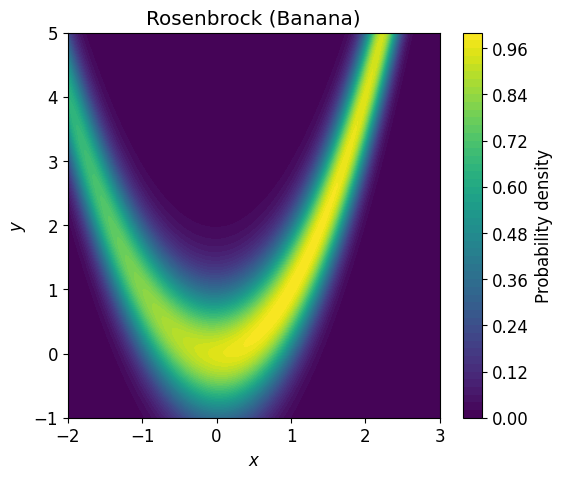

In [3]:
def plot_distribution(log_prob_fn, title, xlim=(-4, 4), ylim=(-4, 4)):
    """Visualize a 2D log probability distribution."""
    x = jnp.linspace(*xlim, 200)
    y = jnp.linspace(*ylim, 200)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, jnp.exp(log_probs), levels=50, cmap="viridis")
    plt.colorbar(label="Probability density")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.title(title)
    plt.show()


plot_distribution(log_prob_rosenbrock, "Rosenbrock (Banana)", xlim=(-2, 3), ylim=(-1, 5))

---
## Baseline 1: Random Walk Metropolis-Hastings

The simplest MCMC method. Proposes isotropic Gaussian steps — no gradient information.

**Tuning tip:** Target ~23-50% acceptance rate. Higher isn't better — it means steps are too small.

In [4]:
def run_rwmh(key, log_prob_fn, initial_position, sigma, n_samples):
    """Run Random Walk Metropolis-Hastings using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        sigma: Proposal standard deviation (scalar or array)
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler with a normal proposal distribution
    rmh = blackjax.rmh(log_prob_fn, blackjax.mcmc.random_walk.normal(sigma))
    initial_state = rmh.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = rmh.step(key, state)
        return state, (state.position, info.is_accepted)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Baseline 2: Hamiltonian Monte Carlo (HMC)

Uses gradient information to make informed proposals. Typically much more efficient than random walk.

**Tuning tip:** Target ~65-90% acceptance rate. Tune step_size first, then n_leapfrog.

In [5]:
def run_hmc(key, log_prob_fn, initial_position, step_size, n_leapfrog, n_samples):
    """Run HMC using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        step_size: Leapfrog step size (epsilon)
        n_leapfrog: Number of leapfrog steps per iteration
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler (identity mass matrix)
    inverse_mass_matrix = jnp.ones(initial_position.shape[0])
    hmc = blackjax.hmc(
        log_prob_fn,
        step_size=step_size,
        inverse_mass_matrix=inverse_mass_matrix,
        num_integration_steps=n_leapfrog,
    )
    initial_state = hmc.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = hmc.step(key, state)
        return state, (state.position, info.acceptance_rate)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Run Baselines on Rosenbrock

In [6]:
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

# Random Walk MH
rwmh_samples, rwmh_acc = run_rwmh(key1, log_prob_rosenbrock, initial_pos, sigma=1.0, n_samples=n_samples)
print(f"RWMH acceptance rate: {rwmh_acc:.2%}")

# HMC
hmc_samples, hmc_acc = run_hmc(
    key2, log_prob_rosenbrock, initial_pos, step_size=0.2, n_leapfrog=10, n_samples=n_samples
)
print(f"HMC acceptance rate: {hmc_acc:.2%}")

RWMH acceptance rate: 50.02%
HMC acceptance rate: 47.20%


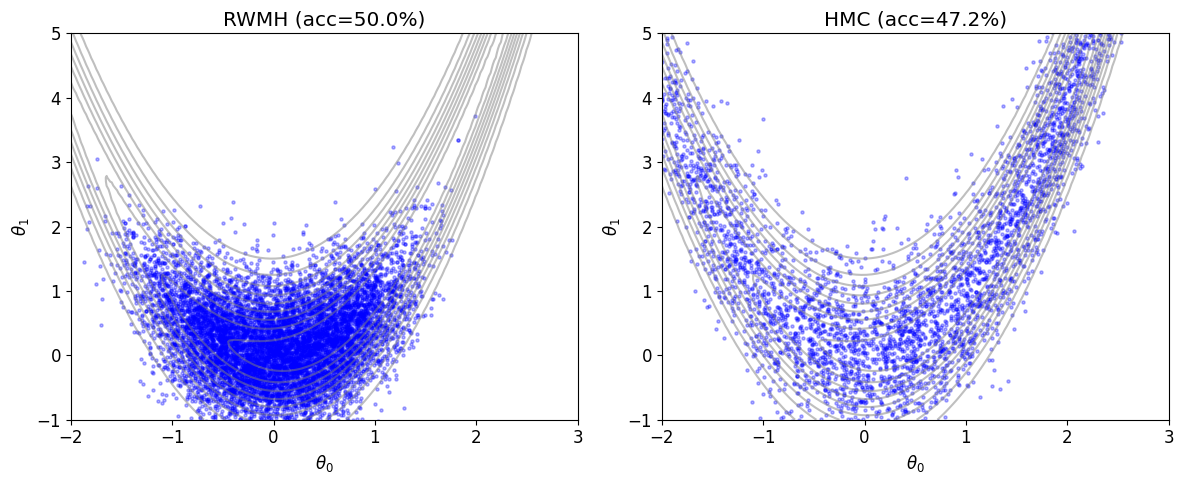

In [7]:
def plot_samples_comparison(samples1, samples2, label1, label2, log_prob_fn, xlim, ylim):
    """Plot samples from two methods side by side."""
    # Compute contours
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, samples, label in zip(axes, [samples1, samples2], [label1, label2]):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::5, 0], samples[::5, 1], alpha=0.3, s=5, c="blue")
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()


plot_samples_comparison(
    rwmh_samples,
    hmc_samples,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"HMC (acc={hmc_acc:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)

---
## Diagnostics with ArviZ

[ArviZ](https://python.arviz.org/) provides standard MCMC diagnostics. Key metrics:
- **Acceptance rate**: Too low = proposals too aggressive; too high = proposals too timid
- **Effective Sample Size (ESS)**: How many independent samples you effectively have
- **Trace plots**: Visual check for mixing and stationarity
- **Autocorrelation**: How correlated successive samples are

In [8]:
def samples_to_inference_data(samples, var_names=None):
    """Convert samples array to ArviZ InferenceData.

    Args:
        samples: Array of shape (n_samples, n_dims)
        var_names: Optional list of variable names

    Returns:
        ArviZ InferenceData object
    """
    if var_names is None:
        var_names = [f"theta_{i}" for i in range(samples.shape[1])]

    # ArviZ expects dict of {var_name: array} with shape (n_chains, n_samples)
    data_dict = {name: samples[None, :, i] for i, name in enumerate(var_names)}
    return az.convert_to_inference_data(data_dict)


def summarize_sampler(samples, name, var_names=None):
    """Print summary statistics for samples using ArviZ."""
    idata = samples_to_inference_data(samples, var_names)
    print(f"\n=== {name} ===")
    display(az.summary(idata, kind="stats"))

In [9]:
# Rosenbrock diagnostics
var_names = ["x", "y"]

rwmh_idata = samples_to_inference_data(rwmh_samples, var_names)
hmc_idata = samples_to_inference_data(hmc_samples, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(rwmh_samples, "RWMH — Rosenbrock", var_names)
summarize_sampler(hmc_samples, "HMC — Rosenbrock", var_names)


=== RWMH — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.048,0.637,-1.105,1.206
y,0.266,0.659,-0.982,1.497



=== HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,1.938,2.272,-2.248,3.955
y,9.334,7.002,-0.052,16.628


RWMH Trace Plots:


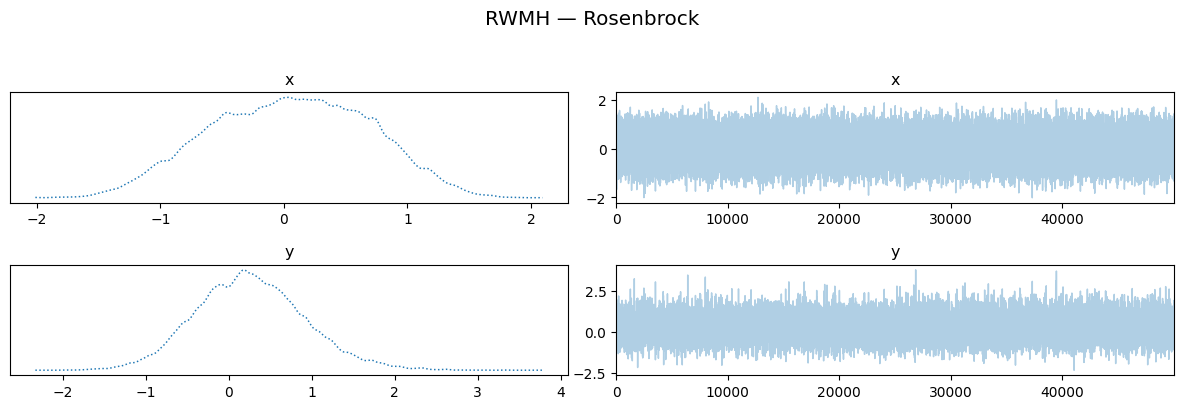


HMC Trace Plots:


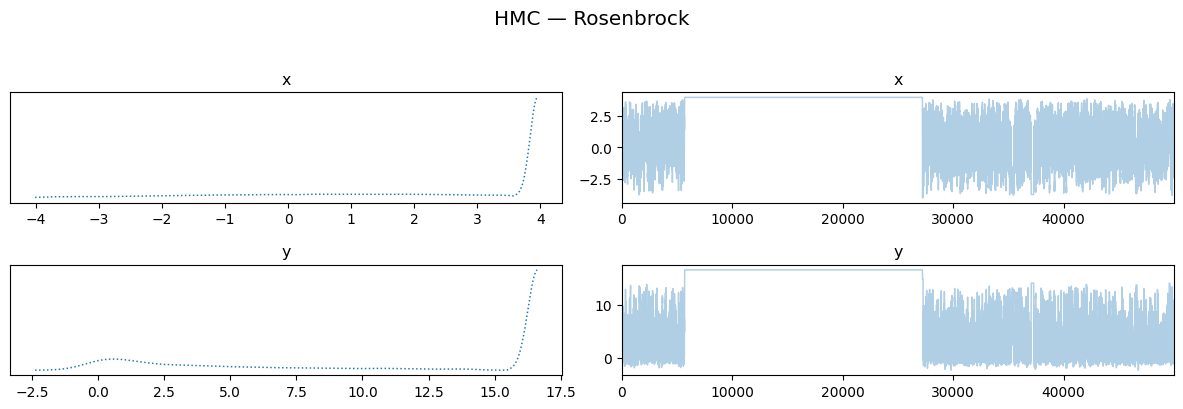

In [10]:
# Trace plots — Rosenbrock
print("RWMH Trace Plots:")
az.plot_trace(rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

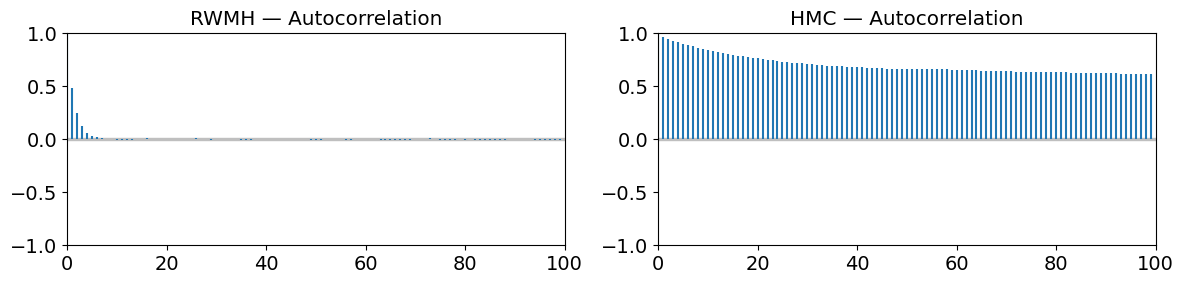

In [11]:
# Autocorrelation — Rosenbrock
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation")
az.plot_autocorr(hmc_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation")
plt.tight_layout()
plt.show()

---
## Discussion: Why Does RWMH Struggle Here?

Look carefully at the results above. You might notice something surprising: RWMH has *lower* autocorrelation than HMC, yet HMC explores the distribution much better. What's going on?

**The issue is local vs. global mixing.** RWMH with isotropic proposals faces a dilemma on curved distributions like the Rosenbrock:
- If the proposal scale is small enough to stay on the narrow ridge, it can't move far along the banana
- If the proposal scale is large enough to explore, most proposals step off the ridge and get rejected

So RWMH ends up jittering locally — samples decorrelate quickly *within* its local neighborhood, but it never traverses the full banana. Low autocorrelation doesn't mean good exploration!

**HMC uses gradients to follow the curve.** It makes long, coherent moves along the ridge without stepping off. The high autocorrelation is just because consecutive samples are along the same trajectory — but they're actually covering the full posterior.

This is exactly the kind of geometry where HMC shines, and one of the main motivations for gradient-based samplers.

---
## Benchmark Distribution 2: Neal's Funnel

Neal's Funnel is a hierarchical distribution that varies dramatically in scale across the space. The narrow "neck" of the funnel is notoriously difficult for fixed step-size samplers.

$$v \sim \mathcal{N}(0, 9), \quad x \sim \mathcal{N}(0, e^v)$$

This means:
- When $v$ is large and positive, $x$ can vary widely
- When $v$ is large and negative, $x$ is tightly constrained near 0
- A single step size can't work well everywhere

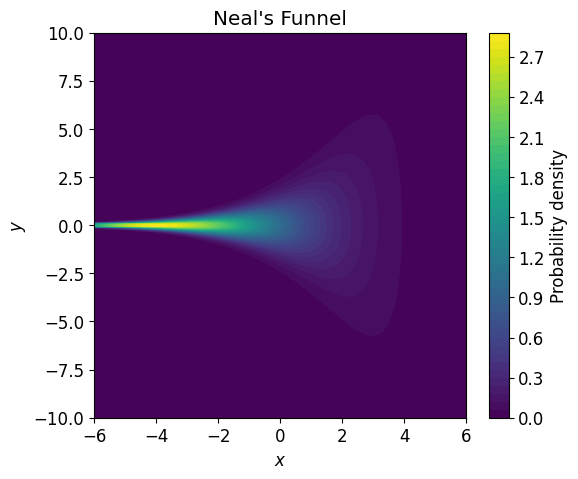

In [12]:
def log_prob_funnel(theta):
    """Neal's Funnel distribution.

    v ~ N(0, 9)
    x ~ N(0, exp(v))

    This creates a funnel shape where the scale of x depends on v.
    The narrow neck (small v) is very hard to sample.
    """
    v, x = theta[0], theta[1]
    log_p_v = -0.5 * v**2 / 9  # v ~ N(0, 9)
    log_p_x_given_v = -0.5 * x**2 * jnp.exp(-v) - 0.5 * v  # x ~ N(0, exp(v))
    return log_p_v + log_p_x_given_v


plot_distribution(log_prob_funnel, "Neal's Funnel", xlim=(-6, 6), ylim=(-10, 10))

In [13]:
# TODO: Run the RWMH and HMC baselines on Neal's Funnel
# Use the same workflow as Rosenbrock above — you'll need to tune hyperparameters!

import pandas as pd

# Initialize [v, x]
initial_pos_funnel = jnp.array([0.0, 0.0])

# Name variables for Funnel surface
funnel_var_names = ["v", "x"]

# --- 1. RWMH Tuning Sweep ---
sigmas = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0]
rwmh_results = []

print("Running RWMH Sweep...")
for s in sigmas:
    samples, acc = run_rwmh(key1, log_prob_funnel, initial_pos_funnel, sigma=s, n_samples=20_000)
    # Effective sample size
    idata = samples_to_inference_data(samples, var_names=funnel_var_names)
    ess = az.ess(idata)
    
    rwmh_results.append({
        "sigma": s,
        "acc": acc,
        "ess_v": float(ess.v),
        "ess_x": float(ess.x)
    })

rwmh_df = pd.DataFrame(rwmh_results)
print(rwmh_df)

# --- 2. HMC Tuning Sweep ---
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
hmc_results = []

print("\nRunning HMC Sweep...")
for e in epsilons:
    # Adjust n_leapfrog to keep the length of path (L*eps) constant (e.g., path_length=1.5)
    n_leap = int(1.5 / e) if e > 0 else 10
    samples, acc = run_hmc(key2, log_prob_funnel, initial_pos_funnel, step_size=e, n_leapfrog=n_leap, n_samples=20_000)
    # Effective sample size
    idata = samples_to_inference_data(samples, var_names=funnel_var_names)
    ess = az.ess(idata)

    hmc_results.append({
        "eps": e,
        "n_leap": n_leap,
        "acc": acc,
        "ess_v": float(ess.v),
        "ess_x": float(ess.x)
    })

hmc_df = pd.DataFrame(hmc_results)
print(hmc_df)

Running RWMH Sweep...
   sigma         acc         ess_v         ess_x
0   0.05      0.9853  18777.563062  18746.231955
1   0.10     0.97185  18117.180654  18426.120185
2   0.20       0.944  16492.772032  18125.188635
3   0.50     0.84975  12347.386833  16768.052616
4   1.00      0.6551   7085.819446  12580.972948
5   2.00  0.38239998   2774.018432   6958.287866

Running HMC Sweep...
    eps  n_leap         acc       ess_v       ess_x
0  0.01     150  0.99964654  208.972467  169.550859
1  0.05      30  0.99079794  214.176645  168.099369
2  0.10      15  0.96369195  161.964672  170.141893
3  0.20       7   0.9296086  206.156061  152.405647
4  0.30       5   0.8908176  163.403261  150.334672
5  0.50       3   0.8020831  108.937095  134.322319


RWMH (Funnel) Final Acceptance Rate: 37.76%
HMC (Funnel) Final Acceptance Rate: 93.20%


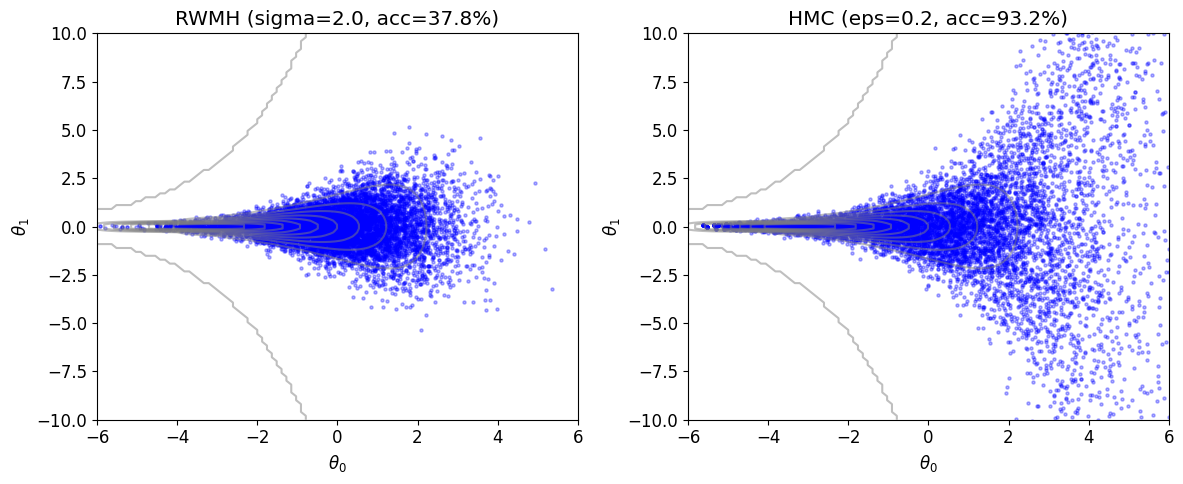


=== RWMH — Neal's Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,-0.299,1.533,-3.188,2.633
x,-0.001,0.959,-1.896,1.952



=== HMC — Neal's Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,0.450,2.896,-4.764,5.843
x,-0.454,7.026,-11.475,13.568


RWMH Funnel Trace Plots:


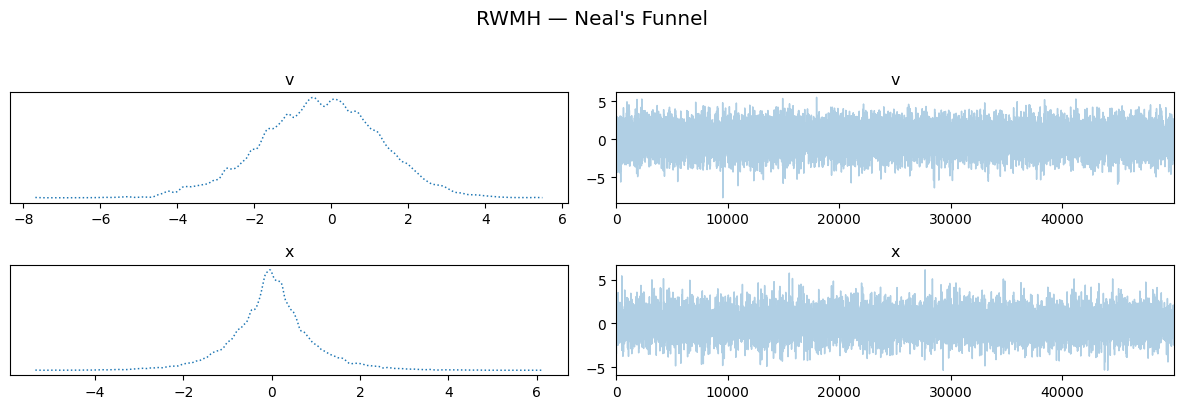


HMC Funnel Trace Plots:


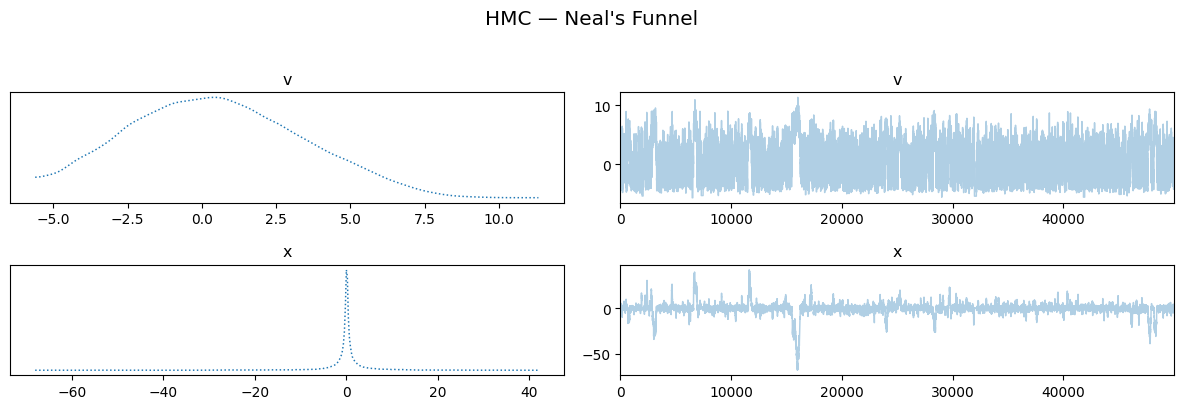

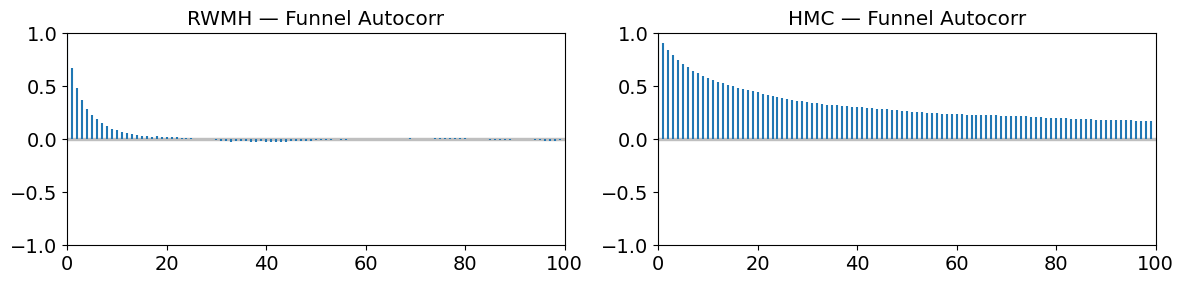

In [14]:
# --- 1. Sampling with the best setting ---
key = jr.PRNGKey(777) # New key for resampling
key1, key2 = jr.split(key)

initial_pos_funnel = jnp.array([0.0, 0.0])
n_samples = 50_000
funnel_var_names = ["v", "x"]

# Best-tuned RWMH
best_rwmh_sigma = 2.0
rwmh_funnel_samples, rwmh_funnel_acc = run_rwmh(
    key1, log_prob_funnel, initial_pos_funnel, sigma=best_rwmh_sigma, n_samples=n_samples
)

# Best-tuned HMC
best_hmc_eps = 0.2
best_hmc_L = 7
hmc_funnel_samples, hmc_funnel_acc = run_hmc(
    key2, log_prob_funnel, initial_pos_funnel, step_size=best_hmc_eps, n_leapfrog=best_hmc_L, n_samples=n_samples
)

print(f"RWMH (Funnel) Final Acceptance Rate: {rwmh_funnel_acc:.2%}")
print(f"HMC (Funnel) Final Acceptance Rate: {hmc_funnel_acc:.2%}")

# --- 2. Sample distribution (Scatter + Contours) ---
plot_samples_comparison(
    rwmh_funnel_samples,
    hmc_funnel_samples,
    f"RWMH (sigma={best_rwmh_sigma}, acc={rwmh_funnel_acc:.1%})",
    f"HMC (eps={best_hmc_eps}, acc={hmc_funnel_acc:.1%})",
    log_prob_funnel,
    xlim=(-6, 6),
    ylim=(-10, 10),
)

# --- 3. ArviZ diagnostics and summary ---
rwmh_funnel_idata = samples_to_inference_data(rwmh_funnel_samples, funnel_var_names)
hmc_funnel_idata = samples_to_inference_data(hmc_funnel_samples, funnel_var_names)

summarize_sampler(rwmh_funnel_samples, "RWMH — Neal's Funnel", funnel_var_names)
summarize_sampler(hmc_funnel_samples, "HMC — Neal's Funnel", funnel_var_names)

# --- 4. Trace Plots (Mixing & Stationarity) ---
print("RWMH Funnel Trace Plots:")
az.plot_trace(rwmh_funnel_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Funnel Trace Plots:")
az.plot_trace(hmc_funnel_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

# --- 5. Autocorrelation (Dependence) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_funnel_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Funnel Autocorr")
az.plot_autocorr(hmc_funnel_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Funnel Autocorr")
plt.tight_layout()
plt.show()

---
## Your Novel Sampler

Now it's your turn! Implement your own sampler below. Some ideas:

- **Adaptive proposals**: Adjust step size based on acceptance rate or local curvature
- **Hybrid methods**: Combine different move types (e.g., local + global moves)
- **Modified dynamics**: Change the Hamiltonian, use different integrators, add friction
- **Tempering**: Use temperature schedules to help exploration

A simple idea with thorough analysis beats a complex idea you don't understand!

In [ ]:
# TODO: Test your sampler on both benchmarks (Rosenbrock and Neal's Funnel)
# my_samples, my_acc = run_my_sampler(key, log_prob_rosenbrock, initial_pos, n_samples=50_000, ...)

In [ ]:
# TODO: Test your sampler on Rosenbrock
# my_samples, my_acc = run_my_sampler(key, log_prob_rosenbrock, initial_pos, n_samples=50_000, ...)

In [15]:
from distributions import ROSENBROCK_TRUE, FUNNEL_TRUE
from sampler       import run_alcs_hmc
from diagnostics   import (plot_distribution, plot_samples_comparison,
                            plot_learned_controller, plot_alpha_trajectories,
                            score_against_truth)
from ablation import run_all_ablations

In [16]:
N_SAMPLES   = 50_000
N_WARMUP    = 10_000
INITIAL_POS = jnp.array([0.0, 0.0])

key = jr.PRNGKey(42)
k1, k2, k3, k4, k5, k6 = jr.split(key, 6)

# # ── Baselines ─────────────────────────────────────────────────────────────
# print("Running RWMH on Rosenbrock …")
# rwmh_samples_rb, rwmh_acc_rb = run_rwmh(
#     k1, log_prob_rosenbrock, INITIAL_POS, sigma=1.0, n_samples=N_SAMPLES)
# print(f"  RWMH acceptance: {rwmh_acc_rb:.2%}")
rwmh_samples_rb, rwmh_acc_rb = rwmh_samples, rwmh_acc

# print("Running HMC on Rosenbrock …")
# hmc_samples_rb, hmc_acc_rb = run_hmc(
#     k2, log_prob_rosenbrock, INITIAL_POS,
#     step_size=0.2, n_leapfrog=10, n_samples=N_SAMPLES)
# print(f"  HMC  acceptance: {hmc_acc_rb:.2%}")
hmc_samples_rb, hmc_acc_rb = hmc_samples, hmc_acc

# print("Running HMC on Neal's Funnel …")
# hmc_samples_fn, hmc_acc_fn = run_hmc(
#     k3, log_prob_funnel, INITIAL_POS,
#     step_size=0.1, n_leapfrog=10, n_samples=N_SAMPLES)
# print(f"  HMC (Funnel) acceptance: {hmc_acc_fn:.2%}")
hmc_samples_fn, hmc_acc_fn = hmc_funnel_samples, hmc_funnel_acc

In [17]:
# ── ALCS-HMC ──────────────────────────────────────────────────────────────
print("\nRunning ALCS-HMC on Rosenbrock …")
rb_result = run_alcs_hmc(
    k4, log_prob_rosenbrock, INITIAL_POS,
    base_step_size=0.2, n_leapfrog=10,
    n_samples=N_SAMPLES, n_warmup=N_WARMUP,
    lr_mlp=3e-4, target_acceptance=0.75,
)
print(f"  ALCS-HMC acceptance (post-warmup): {rb_result['accept_rate_sampling']:.2%}")


Running ALCS-HMC on Rosenbrock …
  ALCS-HMC acceptance (post-warmup): 76.42%


In [18]:
# ── ALCS-HMC ──────────────────────────────────────────────────────────────
print("Running ALCS-HMC on Neal's Funnel …")
fn_result = run_alcs_hmc(
    k5, log_prob_funnel, INITIAL_POS,
    base_step_size=0.1, n_leapfrog=10,
    n_samples=N_SAMPLES, n_warmup=N_WARMUP,
    lr_mlp=3e-4, target_acceptance=0.75,
)
print(f"  ALCS-HMC acceptance (post-warmup): {fn_result['accept_rate_sampling']:.2%}")

Running ALCS-HMC on Neal's Funnel …
  ALCS-HMC acceptance (post-warmup): 97.38%


In [ ]:
# TODO: Compare to baselines
# - Visualize samples (scatter plot with contours)
# - Compute ESS using samples_to_inference_data() and az.summary()
# - Plot traces and autocorrelation
# - Discuss: where does your method work well? Where does it struggle?

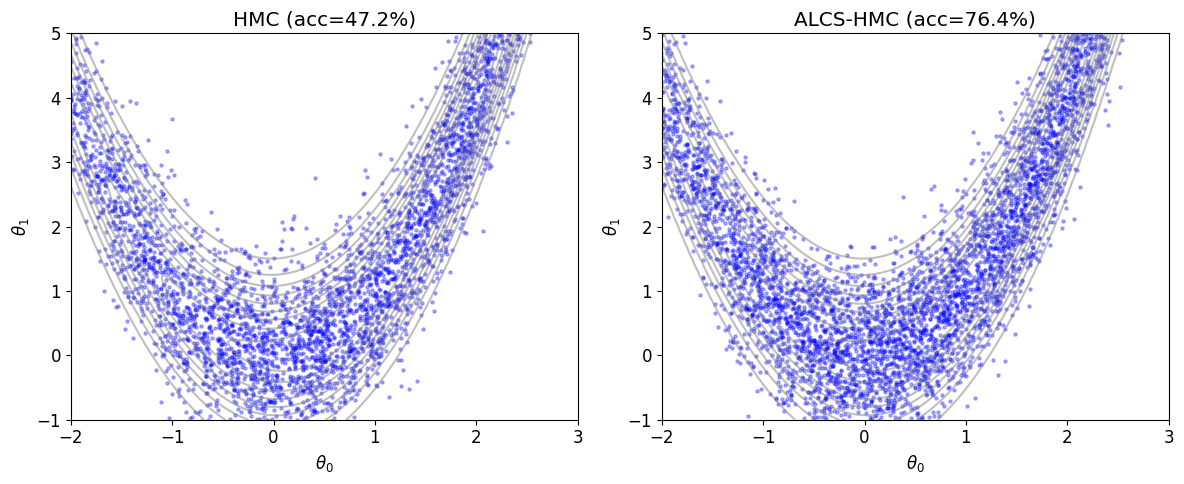

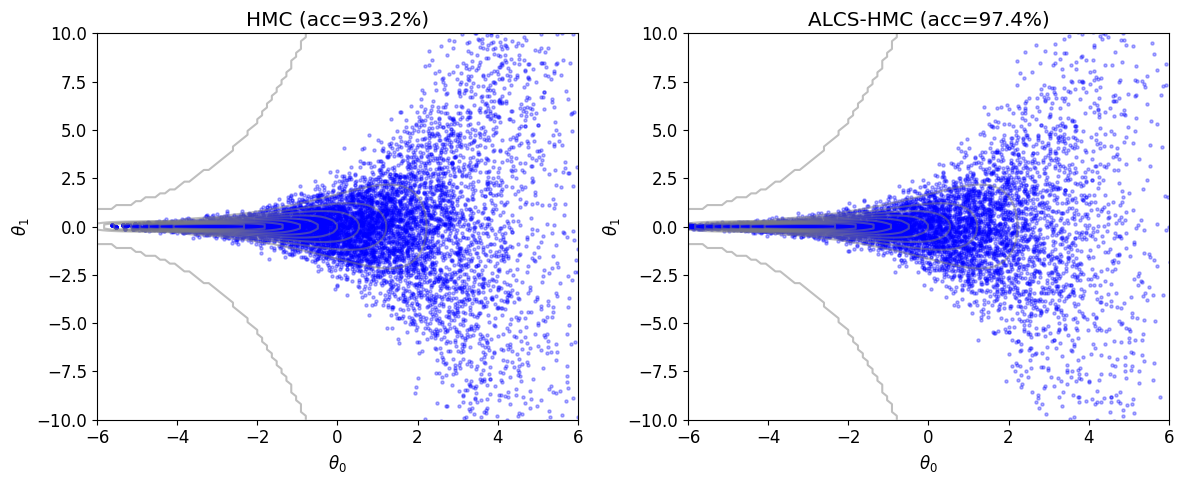

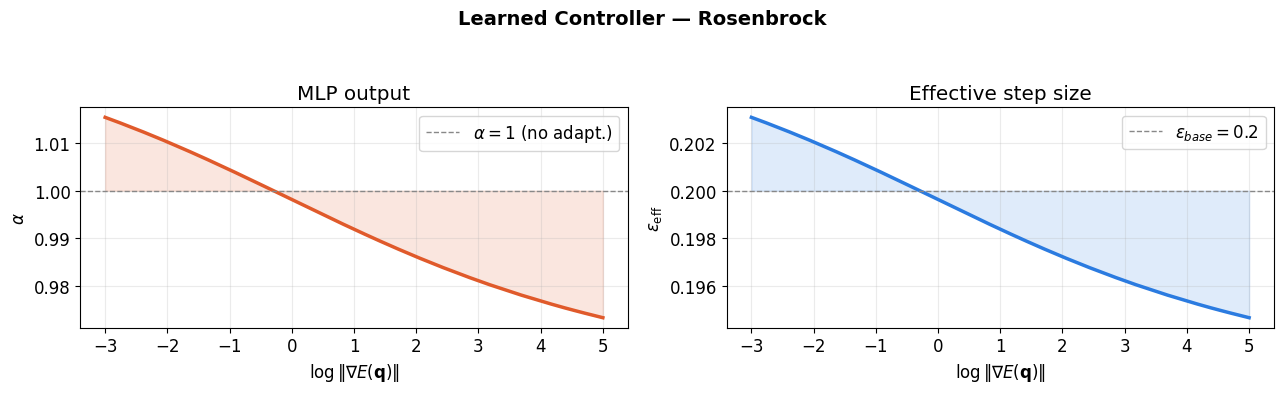

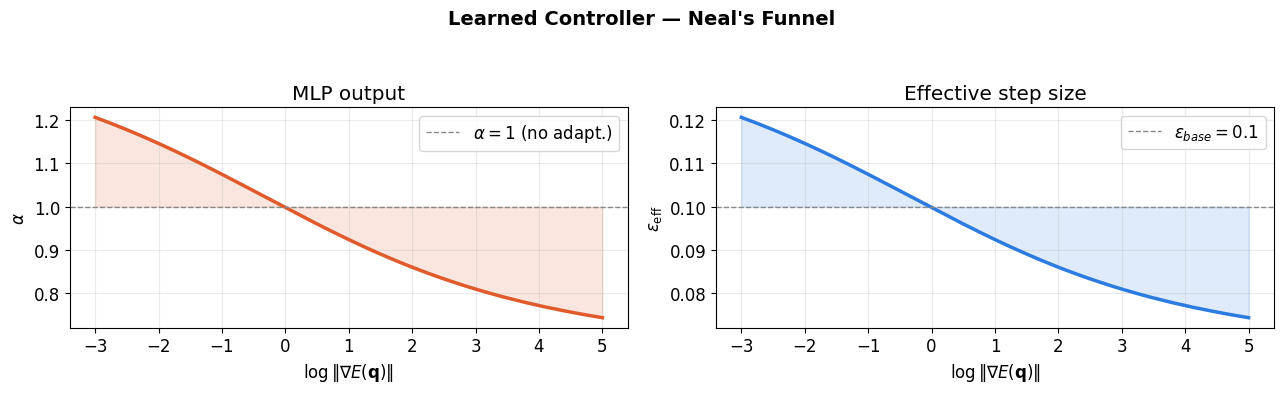

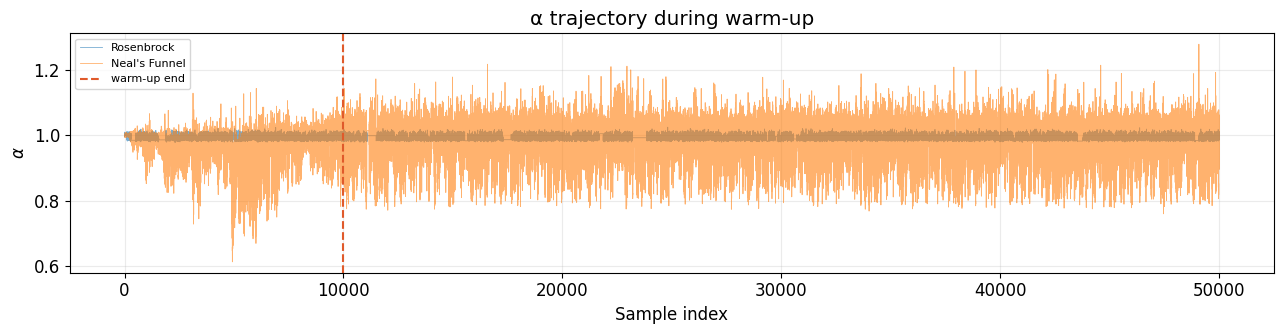

In [19]:
# ── Visualisations ────────────────────────────────────────────────────────
post_rb = rb_result["samples"][N_WARMUP:]
post_fn = fn_result["samples"][N_WARMUP:]

plot_samples_comparison(
    hmc_samples_rb, post_rb,
    f"HMC (acc={hmc_acc_rb:.1%})",
    f"ALCS-HMC (acc={rb_result['accept_rate_sampling']:.1%})",
    log_prob_rosenbrock, xlim=(-2, 3), ylim=(-1, 5))

plot_samples_comparison(
    hmc_samples_fn, post_fn,
    f"HMC (acc={hmc_acc_fn:.1%})",
    f"ALCS-HMC (acc={fn_result['accept_rate_sampling']:.1%})",
    log_prob_funnel, xlim=(-6, 6), ylim=(-10, 10))

plot_learned_controller(rb_result["mlp_params"], base_step_size=0.2,
                        title="Learned Controller — Rosenbrock")
plot_learned_controller(fn_result["mlp_params"], base_step_size=0.1,
                        title="Learned Controller — Neal's Funnel")

plot_alpha_trajectories(
    [("Rosenbrock", rb_result["alphas"]),
        ("Neal's Funnel", fn_result["alphas"])],
    n_warmup=N_WARMUP,
    title="α trajectory during warm-up")


=== Rosenbrock ===

───────────────────────────────────────────────────────
Variable     Truth mean  Sample mean   Truth sd  Sample sd
───────────────────────────────────────────────────────
x                 1.000        1.938      3.162      2.272
y                11.000        9.334      6.500      7.002
───────────────────────────────────────────────────────

───────────────────────────────────────────────────────
Variable     Truth mean  Sample mean   Truth sd  Sample sd
───────────────────────────────────────────────────────
x                 1.000        0.493      3.162      2.159
y                11.000        4.895      6.500      4.715
───────────────────────────────────────────────────────

=== Neal's Funnel ===

───────────────────────────────────────────────────────
Variable     Truth mean  Sample mean   Truth sd  Sample sd
───────────────────────────────────────────────────────
v                 0.000        0.450      3.000      2.896
x                 0.000       -0.4

,mean,sd,hdi_3%,hdi_97%
x,1.938,2.272,-2.248,3.955
y,9.334,7.002,-0.052,16.628



=== ALCS-HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.493,2.159,-3.169,3.947
y,4.895,4.715,-1.008,14.015



=== HMC baseline — Neal's Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,0.450,2.896,-4.764,5.843
x,-0.454,7.026,-11.475,13.568



=== ALCS-HMC — Neal's Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,-0.349,2.855,-5.714,4.714
x,-0.258,3.296,-6.186,6.276


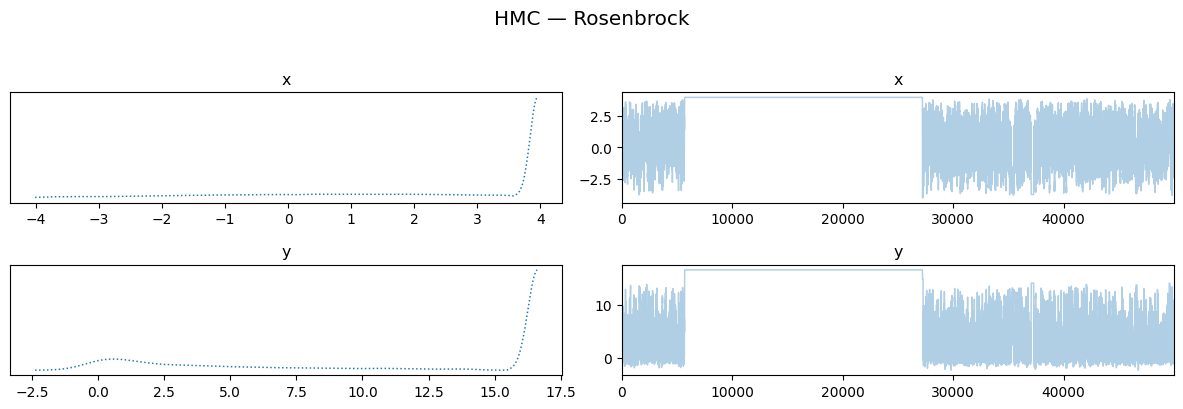

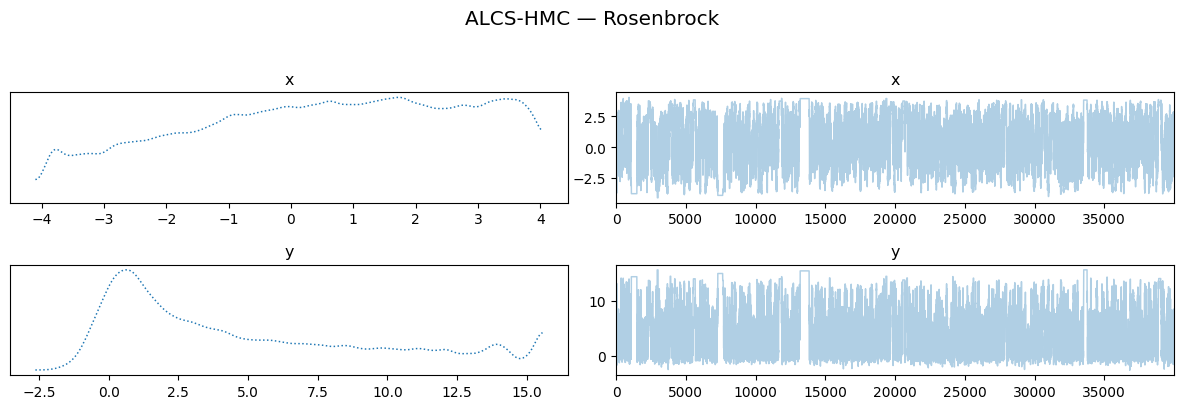

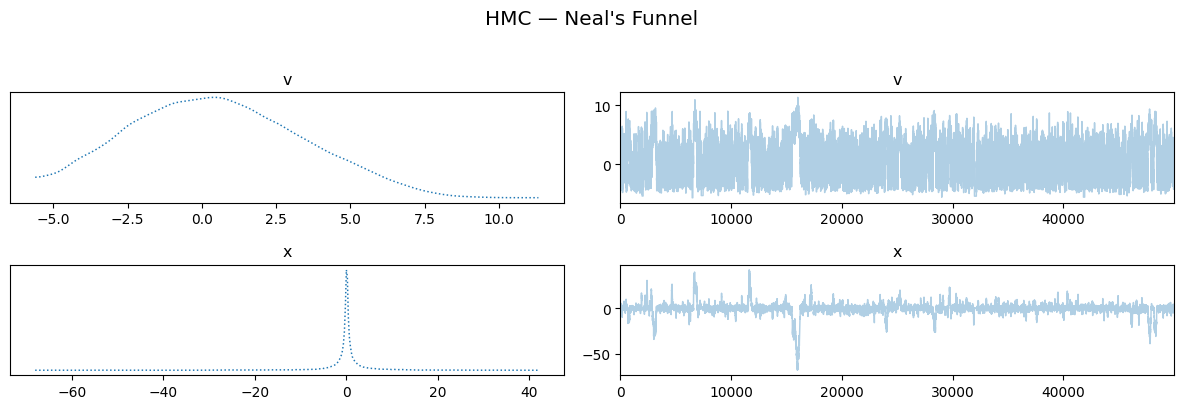

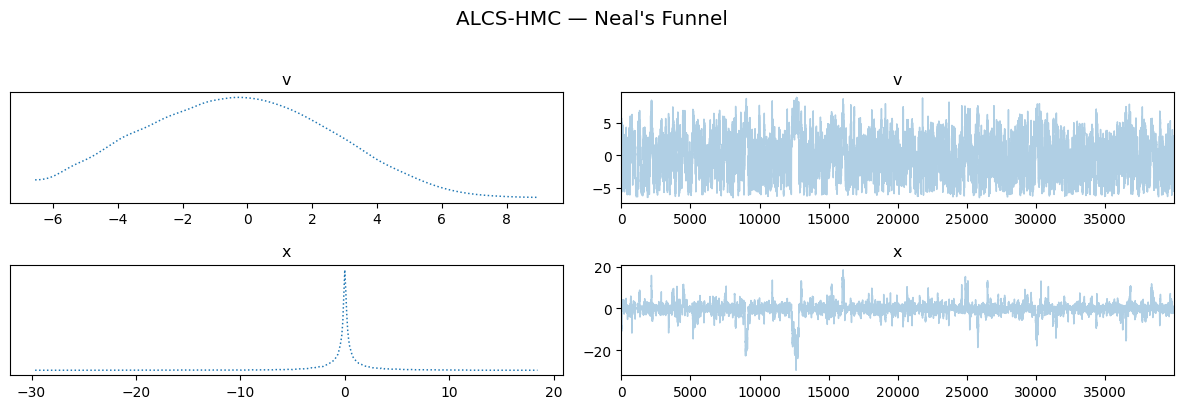

In [20]:
# ── Moment comparison vs ground truth ─────────────────────────────────────
print("\n=== Rosenbrock ===")
score_against_truth(hmc_samples_rb,   ROSENBROCK_TRUE, ["x", "y"])
score_against_truth(post_rb,          ROSENBROCK_TRUE, ["x", "y"])

print("\n=== Neal's Funnel ===")
score_against_truth(hmc_samples_fn,   FUNNEL_TRUE,     ["v", "x"])
score_against_truth(post_fn,          FUNNEL_TRUE,     ["v", "x"])

# ── ArviZ summary ─────────────────────────────────────────────────────────
summarize_sampler(hmc_samples_rb, "HMC baseline — Rosenbrock",  ["x", "y"])
summarize_sampler(post_rb,        "ALCS-HMC — Rosenbrock",      ["x", "y"])
summarize_sampler(hmc_samples_fn, "HMC baseline — Neal's Funnel", ["v", "x"])
summarize_sampler(post_fn,        "ALCS-HMC — Neal's Funnel",   ["v", "x"])

# ── Trace plots ───────────────────────────────────────────────────────────
for idata, title in [
    (samples_to_inference_data(hmc_samples_rb, ["x", "y"]),
        "HMC — Rosenbrock"),
    (samples_to_inference_data(post_rb, ["x", "y"]),
        "ALCS-HMC — Rosenbrock"),
    (samples_to_inference_data(hmc_samples_fn, ["v", "x"]),
        "HMC — Neal's Funnel"),
    (samples_to_inference_data(post_fn, ["v", "x"]),
        "ALCS-HMC — Neal's Funnel"),
]:
    az.plot_trace(idata, combined=True, figsize=(12, 4))
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
# TODO: Ablation study
# - What are the key hyperparameters of your method?
# - How sensitive is performance to each one?
# - What happens in limiting cases (e.g., turning off a component)?


════════════════════════════════════════════════════════════
Ablation study — Rosenbrock
════════════════════════════════════════════════════════════

Q1 — MLP contribution …
Q2 — Warm-up length …
Q3 — Learning rate …
Q4 — Base step size …
Q5 — Loss function …
Q6 — Symmetric step size …

────────────────────────────────────────────────────────────
Q1 — MLP contribution
────────────────────────────────────────────────────────────
                        acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100) loss drop
config                                                                                                                       
fixed α=1.0 (plain HMC)        99.1%          83.1%                1.001                  0.078               0.078     0.000
frozen MLP (untrained)         82.3%          77.8%                1.001                  0.446               1.033    -0.586
trained MLP                    78.0%          82.0%           

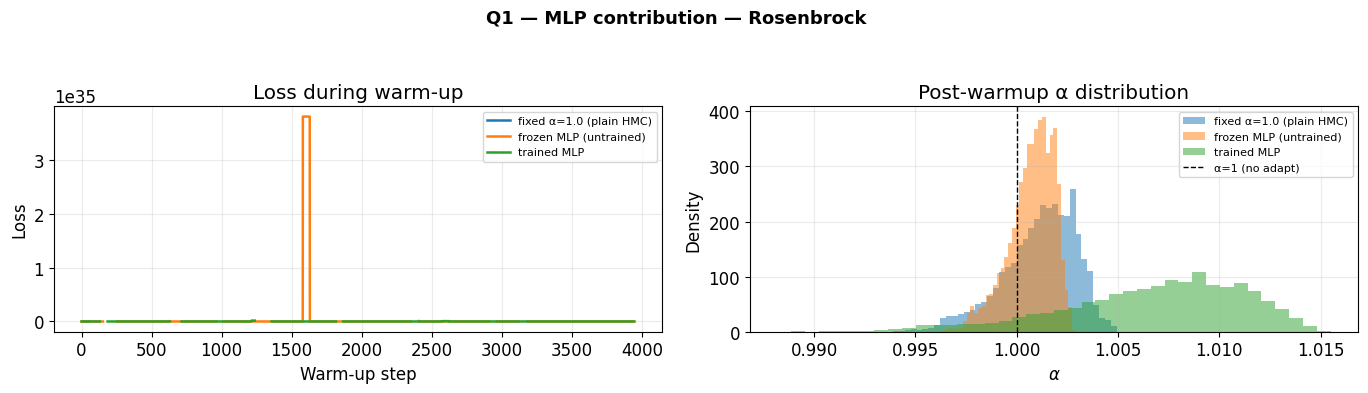


────────────────────────────────────────────────────────────
Q2 — Warm-up length
────────────────────────────────────────────────────────────
             acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100)          loss drop
config                                                                                                                     
n_warmup=5%         80.2%          75.4%                1.014                 78.053    918648520704.000  -918648520704.000
n_warmup=10%        84.0%          74.7%                1.014                 78.053               0.055             77.998
n_warmup=20%        81.1%          74.3%                1.014                 78.053     45822238720.000   -45822238720.000
n_warmup=30%        78.0%          74.6%                1.014                 78.053               0.062             77.991


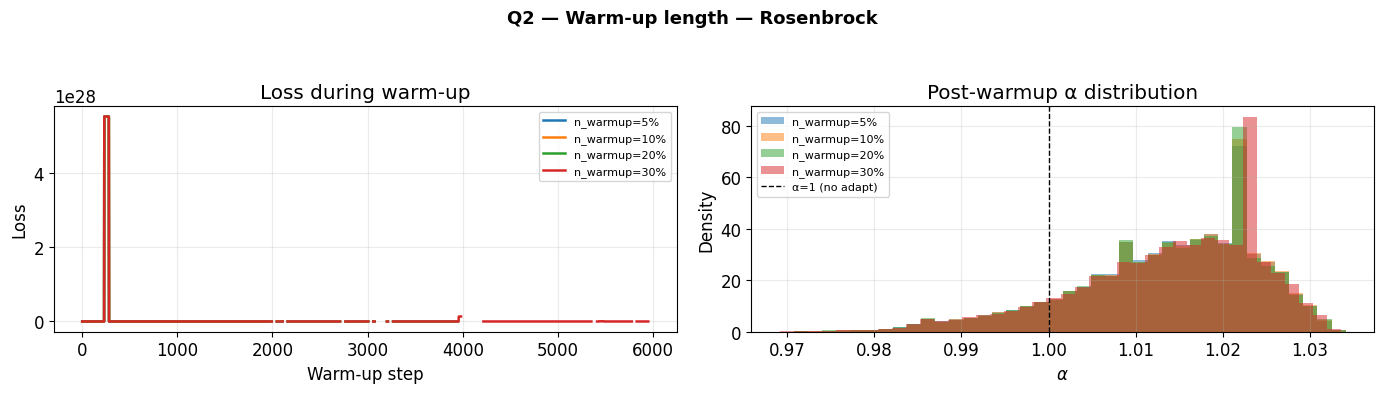


────────────────────────────────────────────────────────────
Q3 — Learning rate
────────────────────────────────────────────────────────────
        acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100)           loss end (last 100)                      loss drop
config                                                                                                                                      
lr=1e-3        83.0%          77.4%                0.982                  1.859                 186531552.000                 -186531552.000
lr=3e-4        82.8%          78.8%                0.995                  2.312  174436717402241286275072.000  -174436717402241286275072.000
lr=1e-4        78.8%          80.6%                0.995                  2.385    2089758610242597289984.000    -2089758610242597289984.000
lr=3e-5        86.0%          84.2%                0.998                  1.978                         1.849                          0.128


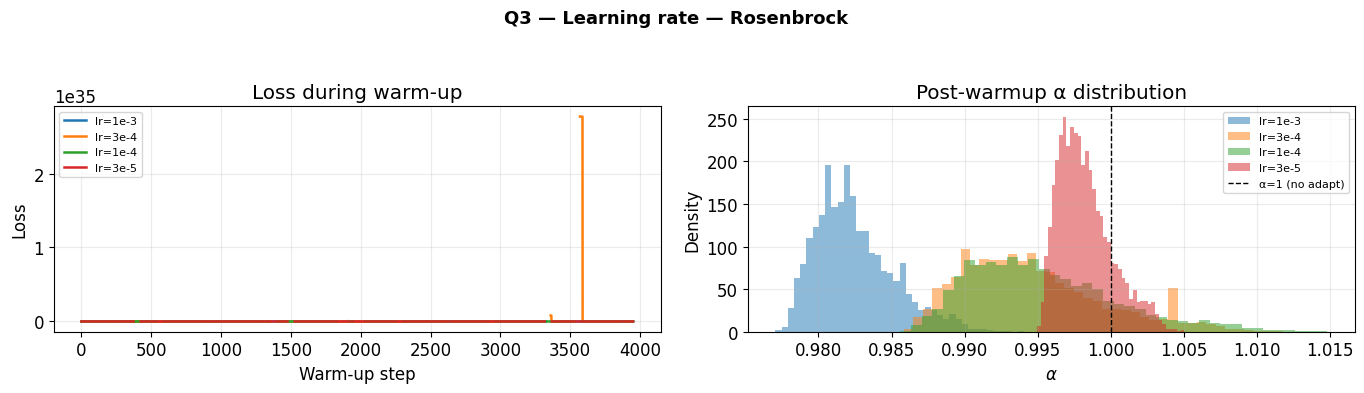


────────────────────────────────────────────────────────────
Q4 — Base step size
────────────────────────────────────────────────────────────
       acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100) loss drop
config                                                                                                      
ε=0.05        91.2%          99.1%                1.354                  0.081               0.060     0.022
ε=0.10        63.6%          46.3%                0.981                  0.071                 inf      -inf
ε=0.20        82.7%          71.6%                0.999                521.915               0.062   521.853
ε=0.30        44.0%          62.5%                1.001                    inf                 inf       nan


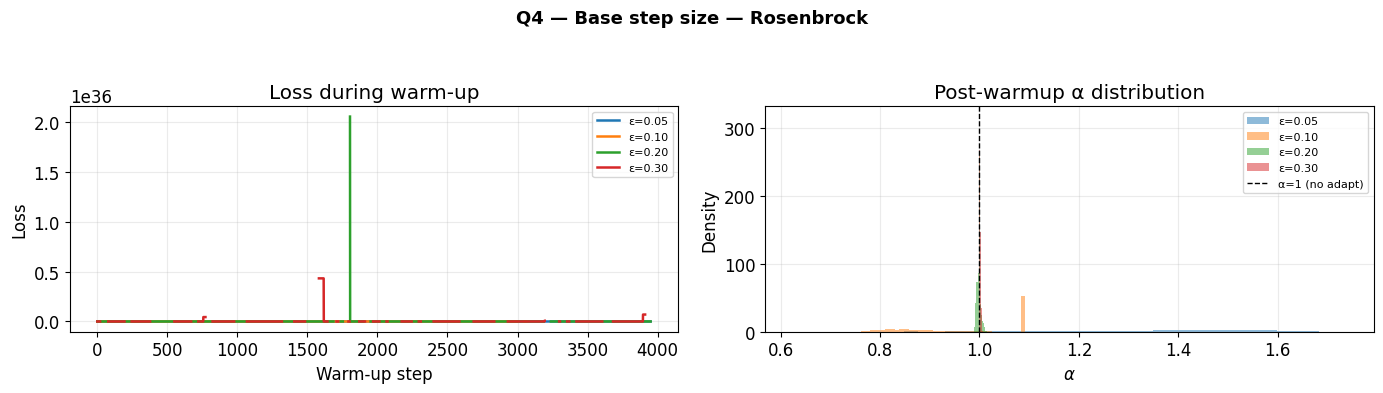


────────────────────────────────────────────────────────────
Q5 — Loss function
────────────────────────────────────────────────────────────
                  acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100) loss drop
config                                                                                                                 
loss=energy_error        81.2%          80.9%                0.992                  0.960             191.506  -190.546
loss=esjd                80.5%          80.8%                1.023                 -3.144              -3.679     0.535


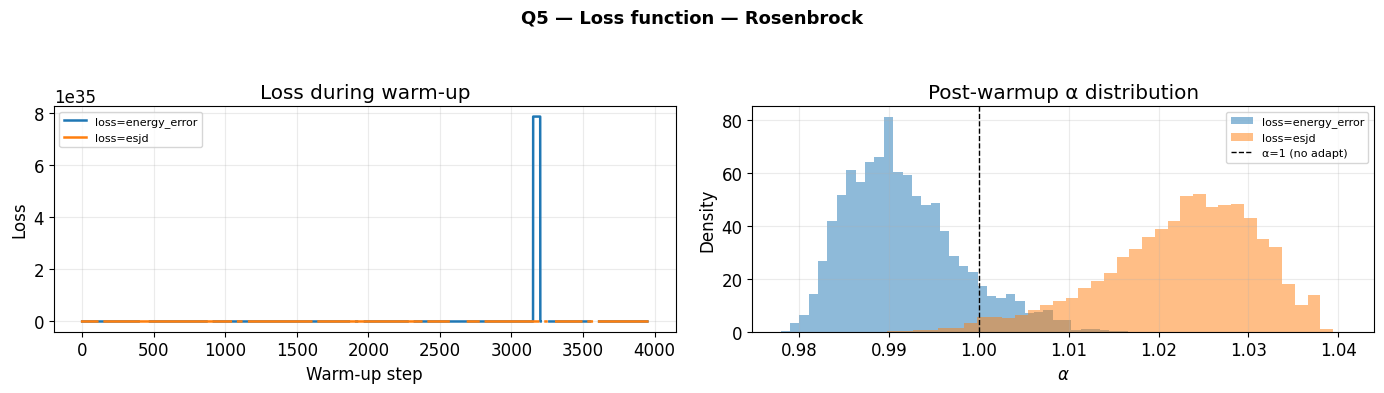


────────────────────────────────────────────────────────────
Q6 — Symmetric step
────────────────────────────────────────────────────────────
                      acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100)      loss drop
config                                                                                                                          
asymmetric (original)        84.7%          39.3%                0.995          169883232.000            3837.482  169879392.000
symmetric (Fix B)            80.5%          78.8%                0.994                 13.196              12.972          0.224


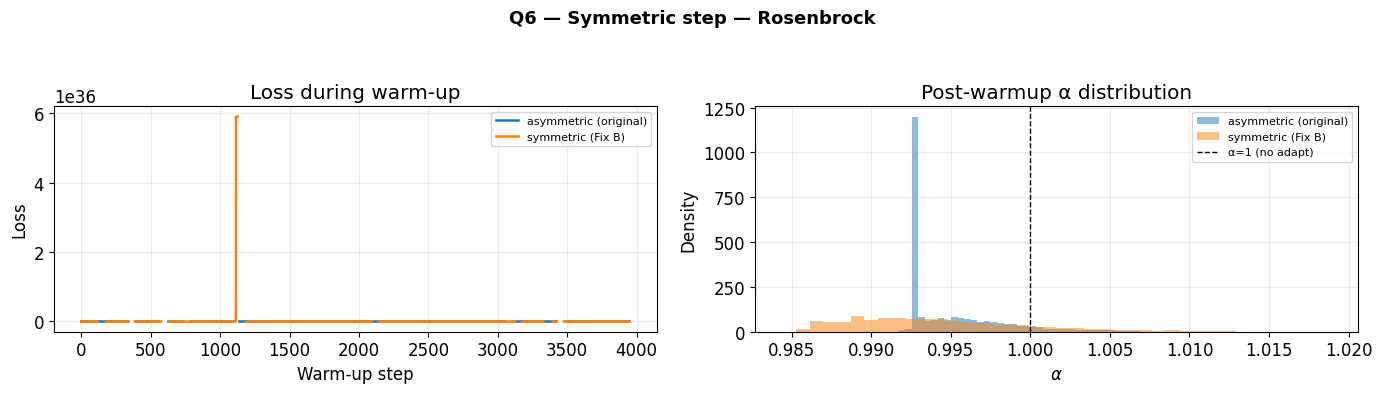


════════════════════════════════════════════════════════════
Ablation study — Neal's Funnel
════════════════════════════════════════════════════════════

Q1 — MLP contribution …
Q2 — Warm-up length …
Q3 — Learning rate …
Q4 — Base step size …
Q5 — Loss function …
Q6 — Symmetric step size …

────────────────────────────────────────────────────────────
Q1 — MLP contribution
────────────────────────────────────────────────────────────
                        acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100)   loss drop
config                                                                                                                         
fixed α=1.0 (plain HMC)        99.6%          97.8%                1.000                  0.081               0.081       0.000
frozen MLP (untrained)         95.3%          97.8%                1.000                  0.874               0.082       0.792
trained MLP                    97.7%          98.3%

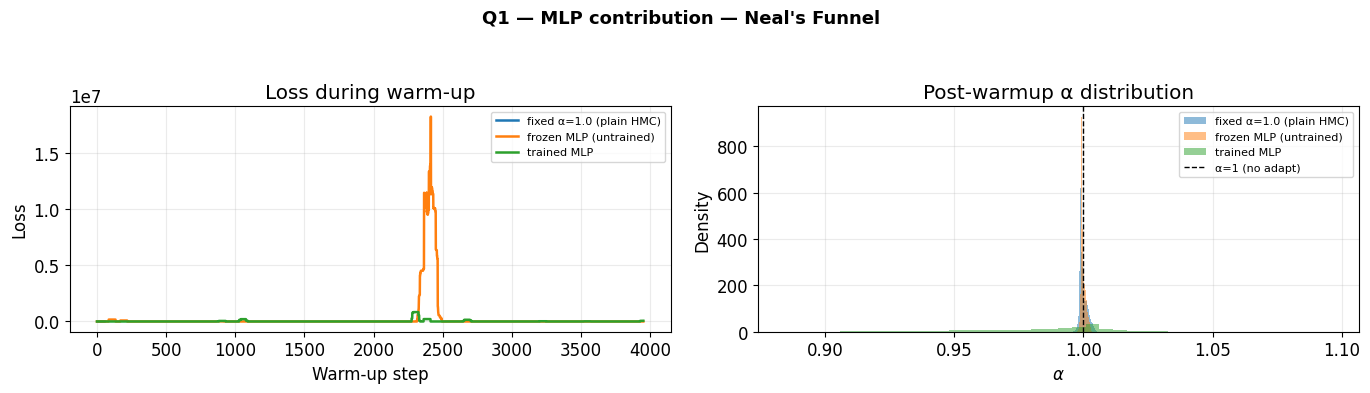


────────────────────────────────────────────────────────────
Q2 — Warm-up length
────────────────────────────────────────────────────────────
             acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100) loss drop
config                                                                                                            
n_warmup=5%         99.6%          96.4%                1.039                  0.079               0.069     0.010
n_warmup=10%        99.0%          97.2%                1.034                  0.079               0.073     0.006
n_warmup=20%        98.4%          97.0%                1.033                  0.079               0.520    -0.441
n_warmup=30%        98.8%          96.6%                1.053                  0.079               0.082    -0.003


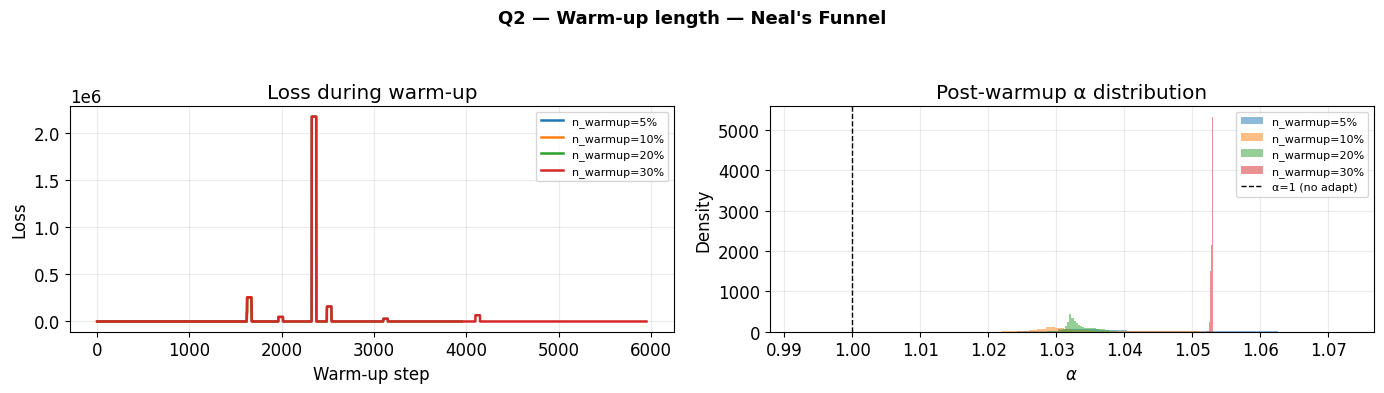


────────────────────────────────────────────────────────────
Q3 — Learning rate
────────────────────────────────────────────────────────────
        acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100)       loss drop
config                                                                                                             
lr=1e-3        97.0%          93.9%                0.816             118834.445               0.072      118834.375
lr=3e-4        96.8%          94.5%                0.949         1044267200.000               0.071  1044267200.000
lr=1e-4        96.3%          97.7%                0.972            7466480.500               0.073     7466480.500
lr=3e-5        95.4%          97.8%                0.988              31517.117               0.074       31517.043


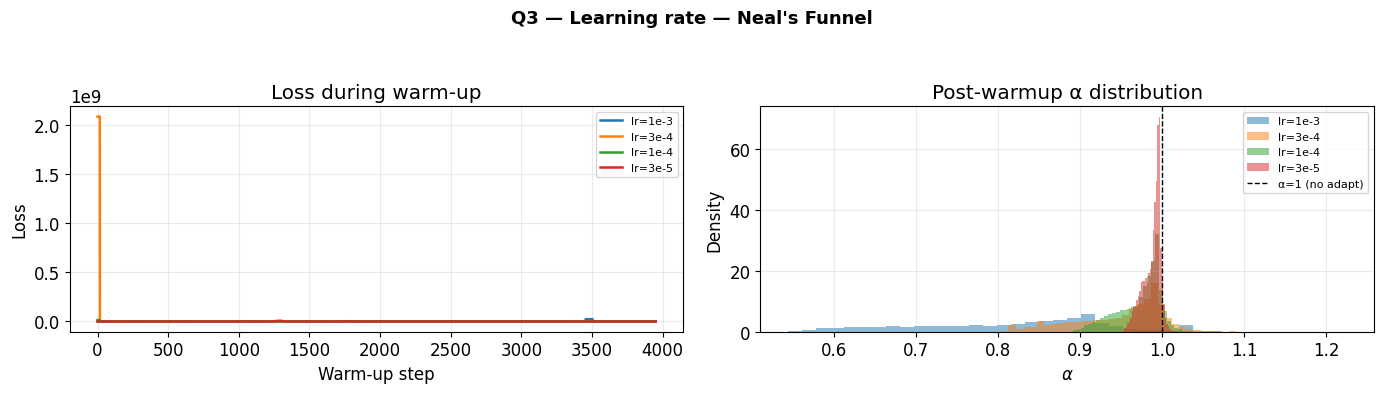


────────────────────────────────────────────────────────────
Q4 — Base step size
────────────────────────────────────────────────────────────
       acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100)    loss drop
config                                                                                                         
ε=0.05        99.8%          98.2%                1.336                  0.083               0.081        0.001
ε=0.10        98.8%          83.7%                1.030                  0.081               0.074        0.008
ε=0.20        95.0%          93.8%                0.934               6704.935          714111.125  -707406.188
ε=0.30        90.8%          91.8%                0.700               7013.925          464386.562  -457372.625


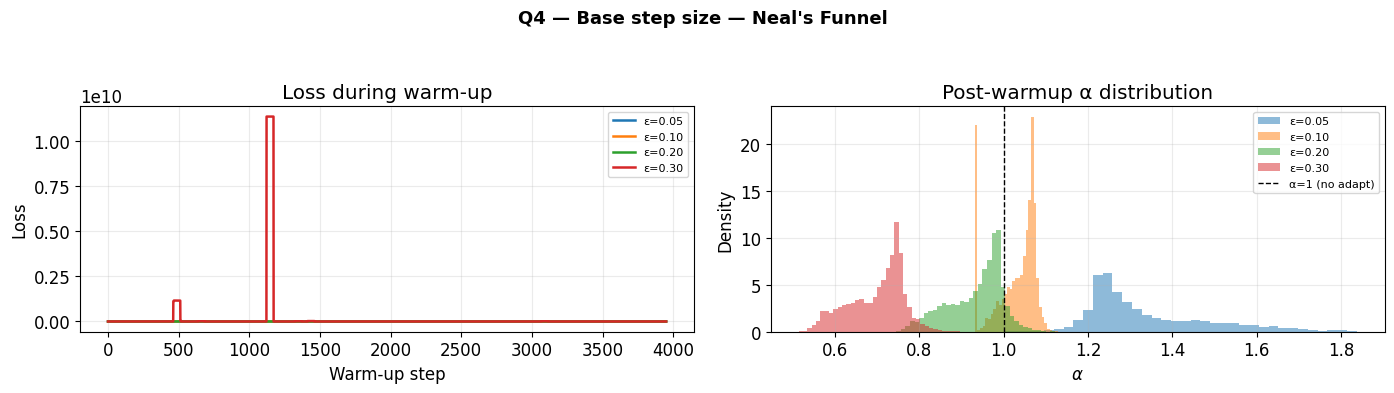


────────────────────────────────────────────────────────────
Q5 — Loss function
────────────────────────────────────────────────────────────
                  acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100)   loss drop
config                                                                                                                   
loss=energy_error        97.3%          97.7%                0.992                  0.081           12732.560  -12732.479
loss=esjd                91.1%          89.0%                2.500                 -1.931              -6.811       4.879


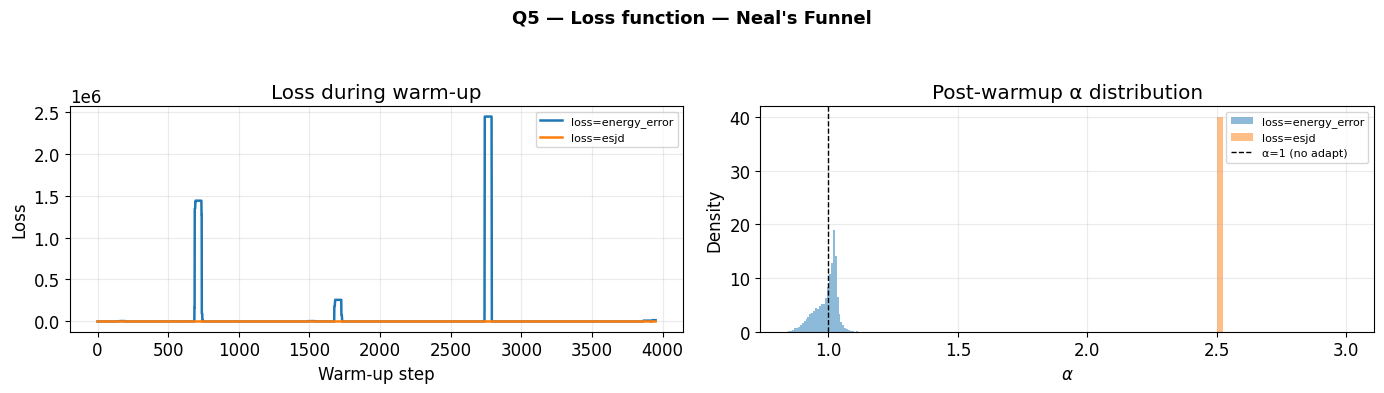


────────────────────────────────────────────────────────────
Q6 — Symmetric step
────────────────────────────────────────────────────────────
                      acc_warmup % acc_sampling % mean α (post-warmup) loss start (first 100) loss end (last 100)   loss drop
config                                                                                                                       
asymmetric (original)        98.7%          96.4%                1.013                  0.074           35026.484  -35026.410
symmetric (Fix B)            98.6%          97.9%                1.033                  0.197               0.076       0.121


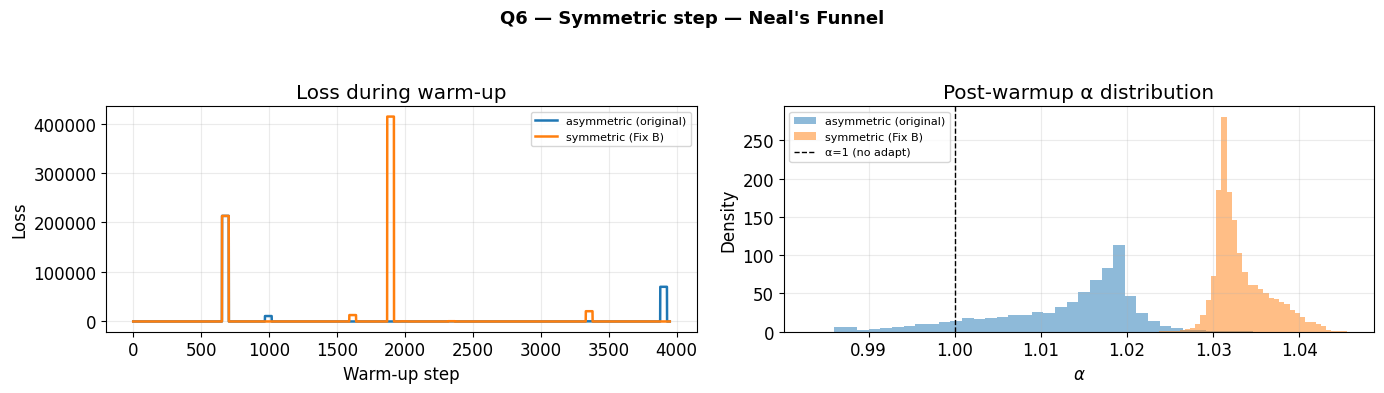

{'Q1 — MLP contribution': {'fixed α=1.0 (plain HMC)': {'samples': Array([[-1.728889  , -0.4943734 ],
          [-1.253573  , -0.1636354 ],
          [-0.420987  , -0.53196055],
          ...,
          [ 1.4031241 , -1.5769643 ],
          [ 2.1551785 , -2.4440906 ],
          [ 1.41648   , -2.7769356 ]], dtype=float32),
   'accept_rate_warmup': 0.9962292313575745,
   'accept_rate_sampling': 0.9784860610961914,
   'alphas': Array([0.9986824 , 1.0014439 , 0.99910957, ..., 0.99860823, 0.9987521 ,
          0.9986331 ], dtype=float32),
   'warmup_losses': Array([0.0806016], dtype=float32),
   'mlp_params': [{'W': Array([[-0.3021009 ,  0.1393709 , -0.05057293, -0.2667416 , -0.141663  ,
             -0.03245486, -0.21590216, -0.04554425,  0.09039824, -0.04858172,
             -0.3136888 , -0.16687873, -0.15569311,  0.1835903 , -0.02764917,
              0.1554029 ]], dtype=float32),
     'b': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)},
    {

In [21]:
run_all_ablations(log_prob_rosenbrock, INITIAL_POS,
                    base_step_size=0.2,
                    distribution_name="Rosenbrock")
run_all_ablations(log_prob_funnel, INITIAL_POS,
                    base_step_size=0.1,
                    distribution_name="Neal's Funnel")